# Markov Chain Monte Carlo

**Definition: ** A Markov Chain Monte Carlo (MCMC) method for simulation of a distribution $p$ is any simulation method that produce an ergodic Markov Chain whose stationary distribution is $p$.

Broadly speaking a MCMC algorithm works as follows: from an arbitrary starting point $x^{(0)}$, a markov chain $(x^{(t)})_t$ is generated using a transition kernel with stationary distribution $p$, which ensures the convergence in distribution of $(X^{(t)})_t$ to $p$. Given the chain is ergodic, the starting value does not matter

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i)}$
Draw $\theta'\sim q(\theta'|\theta)$
2. Compute $r=\min(1,\alpha)$ , where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$ is the _acceptance ratio_
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

Where $p(\theta)$ is the distribution we want to sample from (i.e. the posterior), and $q(\theta)$ is the proposal density (or _jumping distribution_) of the MC innovation. The proposal density $q(\theta)$ must be proportional to to the distribution of interest $p(\theta)$. Usual choices for $q(\theta)$ are the _Normal_ and _t distributions_.

---

Notice that given two states $(\theta',\theta)$ the probability of accepting the movement from $\theta$ to $\theta'$ is given by

$$P(\text{ Accept a move })= P(u<r)=r\equiv r(\theta'|\theta)$$

thus we can write the MH Kernel as

$$K(\theta,\theta')=q(\theta'|\theta)r(\theta'|\theta)+1\{\theta'=\theta\}\int q(\theta'|\theta)\left(1-r(\theta'|\theta)\right)\mathrm{d}\theta'  $$

To show that the stationary distribution of the MH Kernel above is actually the posterior $p$ consider without loss of generality that two states $(\theta',\theta)$ result in $p(\theta)q(\theta'|\theta)>p(\theta')q(\theta|\theta')$, hence $\alpha<1$ and consequently $r(\theta'|\theta)=\alpha$ and $r(\theta|\theta')=1$ since $r=\min(1,\alpha)$. Thus

$$K(\theta,\theta')=q(\theta'|\theta)r(\theta'|\theta)=\frac{p(\theta')q(\theta|\theta')}{p(\theta)}\iff p(\theta)K(\theta,\theta')=p(\theta')q(\theta|\theta')$$

Since $K(\theta',\theta)=q(\theta|\theta')r(\theta|\theta')= q(\theta|\theta')$, we conclude that 

$$p(\theta)K(\theta,\theta')=p(\theta')K(\theta',\theta)$$

Therefore the stationarity of $p$ is established for any proposal distribution $q$ that satisfies this minimum requirement

$$\text{support $(p)$}\subseteq \text{support $\left(\bigcup_\theta q(.|\theta)\right)$ }$$

This condition can translated as: $q$ is admissible if it has positive probability to move the Markov Chain to areas where the posterior has positive density. In practice, we choose an easy to sample $q$. There are also some convergence consideration that we will discuss further on.

### Random Walk Chains

If we set our moves in a random walk fashion as in

$$\theta'=\theta +\nu,\quad \nu\sim f_{\nu}$$

then, we have that the proposal density becomes

$$q(\theta'|\theta)=f_\nu(\theta'-\theta)$$

If $\nu$ has a symmetric distribution around $0$, i,e. $f_\nu(x)=f_\nu(-x)$, we have the a symmetric proposal distribution since

$$q(\theta'|\theta)=f_\nu(\theta'-\theta)=f_\nu(\theta-\theta')=q(\theta|\theta')$$

In that case the the Hasting Correction term $\frac{q(\theta|\theta')}{q(\theta'|\theta)}=1$ consequently $\alpha=\frac{p(\theta')}{p(\theta)}$ and the acceptance probability simply to

$$r = min\left(1,\frac{p(\theta')}{p(\theta)}\right) $$

In [1]:
## Normal random walk Metropolis-Hastings
import numpy as np
import pandas as pd

def RWMH(n,p,k):
    theta=0
    
    sample = pd.DataFrame({'theta':np.nan},index=range(n))
    sample.theta[0] = theta
    
    i=1
    while(i<n):
        # Draw q(theta1 | theta0)
        newTheta = theta + np.random.normal(0,k)

        # Compute acceptance ratio
        acceptanceRatio = np.log(p(newTheta))-np.log(p(theta))

        # Compute r = min(1,acceptance ratio)
        r = min(1,np.exp(acceptanceRatio))

        # Accept or reject new theta
        u = np.random.uniform(0,1)

        if u<r:
            theta = newTheta
            sample.theta[i] = theta
            i = i+1
            
    return sample


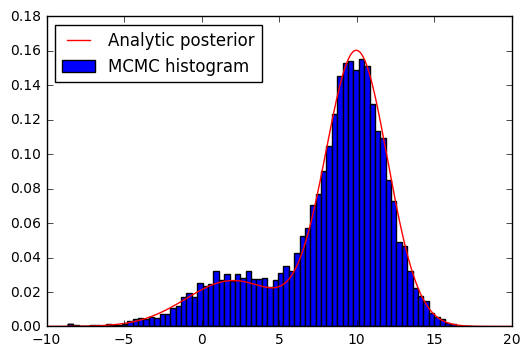

In [6]:
from scipy import stats
import matplotlib.pyplot as plt

def p(x):       # posterior distribution we want to sample from
    return 0.8*stats.norm(10,2).pdf(x)+0.2*stats.norm(2,3).pdf(x)

n=10000         # sample size
burn_in = .1    # "training" sample set to 10%

sample = RWMH(n,p,2)[int(-(1-burn_in)*n):]

# Plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

## Plot MCMC sample
ax.hist(sample['theta'], bins=75, normed=True);

## Plot analytic posterior
X = np.linspace(-10,20, 5000)
ax.plot(X, p(X), 'r');

## Plot rejection sampling bound
#ax.plot(X, np.ones(1000)*M, 'g');

# Cleanup
ax.legend(['Analytic posterior','MCMC histogram'],loc='best');

#print('Acceptance ratio: '+str(sample.shape[0]/df.shape[0]))
fig